<a href="https://colab.research.google.com/github/anushkaiit22/DeepFake-Detection/blob/main/first_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers, Model

In [ ]:
dataset_path ='/content/drive/MyDrive/dataset/train'

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(256, 256),
    batch_size=32
)
val_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(256, 256),
    batch_size=32
)
class_names = val_dataset.class_names
print("Class names:", class_names)

Found 1000 files belonging to 2 classes.
Using 800 files for training.
Found 1000 files belonging to 2 classes.
Using 200 files for validation.
Class names: ['fake', 'real']


In [ ]:
test_path ='/content/drive/MyDrive/dataset/test'

In [ ]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.1,
    subset="validation",
    seed=123,
    image_size=(256, 256),
    batch_size=32
)

Found 1000 files belonging to 2 classes.
Using 100 files for validation.


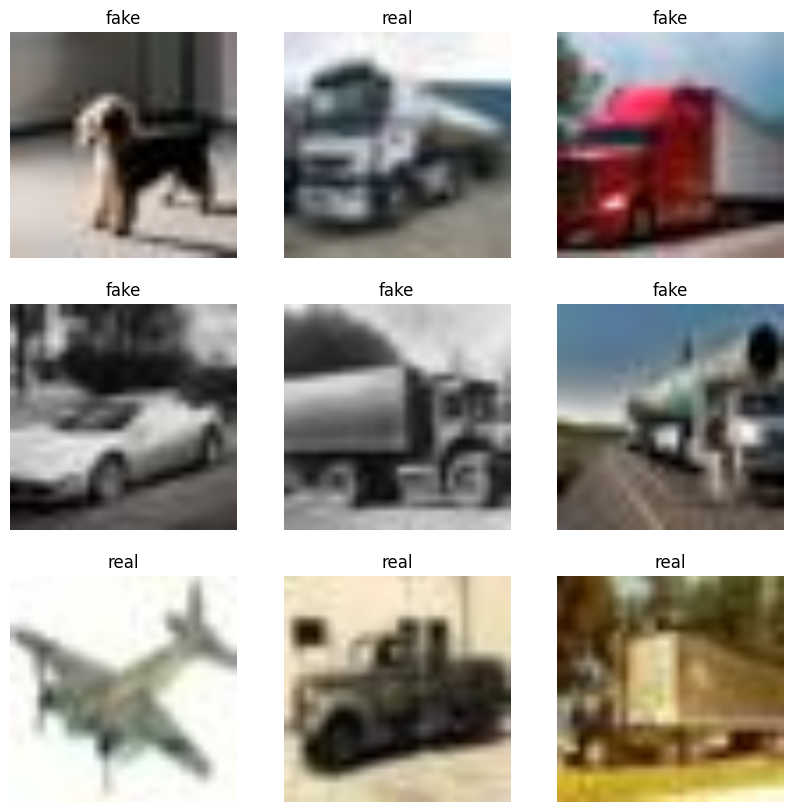

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)
base_model.trainable = False

inputs = tf.keras.Input(shape=(256, 256, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(len(class_names))(x)

model = tf.keras.Model(inputs, outputs)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(train_dataset, epochs=3, validation_data=val_dataset)

Epoch 1/3
25/25 [==============================] - 261s 10s/step - loss: 0.8582 - accuracy: 0.5337 - val_loss: 0.6931 - val_accuracy: 0.4600
Epoch 2/3
25/25 [==============================] - 244s 10s/step - loss: 0.6931 - accuracy: 0.5275 - val_loss: 0.6931 - val_accuracy: 0.5650
Epoch 3/3
25/25 [==============================] - 246s 10s/step - loss: 0.6931 - accuracy: 0.5400 - val_loss: 0.6931 - val_accuracy: 0.5800


just building a simple model with some conv layers (just picked it from gfg !) it was for dicriminator of a GAN

---



---



In [ ]:
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(32, kernel_size=3, strides=2, padding='same', input_shape=(256, 256, 3)),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.25),

        layers.Conv2D(64, kernel_size=3, strides=2, padding='same'),
        layers.ZeroPadding2D(((0,1), (0,1))),
        layers.BatchNormalization(momentum=0.82),
        layers.LeakyReLU(alpha=0.25),
        layers.Dropout(0.25),

        layers.Conv2D(128, kernel_size=3, strides=2, padding='same'),
        layers.BatchNormalization(momentum=0.82),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.25),

        layers.Conv2D(256, kernel_size=3, strides=1, padding='same'),
        layers.BatchNormalization(momentum=0.8),
        layers.LeakyReLU(alpha=0.25),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

discriminator_model = build_discriminator()
discriminator_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 128, 128, 32)      0         
                                                                 
 dropout_4 (Dropout)         (None, 128, 128, 32)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 zero_padding2d_1 (ZeroPadd  (None, 65, 65, 64)        0         
 ing2D)                                                          
                                                                 
 batch_normalization_3 (Bat  (None, 65, 65, 64)        256       
 chNormalization)                                     

In [ ]:
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

In [ ]:
#@tf.function can speed up the training loop by compiling it into a TensorFlow graph
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = discriminator_model(images, training=True)
        loss = loss_fn(labels, predictions)
    gradients = tape.gradient(loss, discriminator_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, discriminator_model.trainable_variables))
    return loss

@tf.function
def val_step(images, labels):
    predictions = discriminator_model(images, training=False)
    loss = loss_fn(labels, predictions)
    return loss

def train_discriminator(train_dataset, val_dataset, epochs=10):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        train_loss = 0.0
        for images, labels in train_dataset:
            labels = tf.expand_dims(tf.cast(labels, tf.float32), axis=-1)
            train_loss += train_step(images, labels)

        print(f"Training Loss: {train_loss / len(train_dataset)}")

        val_loss = 0.0
        for images, labels in val_dataset:
            labels = tf.expand_dims(tf.cast(labels, tf.float32), axis=-1)
            val_loss += val_step(images, labels)

        print(f"Validation Loss: {val_loss / len(val_dataset)}")

train_discriminator(train_dataset, val_dataset, epochs=10)

Epoch 1/10
Training Loss: 1.2386244535446167
Validation Loss: 0.9463172554969788
Epoch 2/10
Training Loss: 0.9206510186195374
Validation Loss: 1.6050208806991577
Epoch 3/10
Training Loss: 0.6595174670219421
Validation Loss: 1.8418362140655518
Epoch 4/10
Training Loss: 0.6970255970954895
Validation Loss: 1.5416433811187744
Epoch 5/10
Training Loss: 0.6118095517158508
Validation Loss: 1.522985577583313
Epoch 6/10
Training Loss: 0.5918470025062561
Validation Loss: 2.0619397163391113
Epoch 7/10
Training Loss: 0.7173396348953247
Validation Loss: 1.3107738494873047
Epoch 8/10
Training Loss: 0.6897873878479004
Validation Loss: 2.2653489112854004
Epoch 9/10
Training Loss: 0.5750057697296143
Validation Loss: 1.4576646089553833
Epoch 10/10
Training Loss: 0.4283248484134674
Validation Loss: 1.7655658721923828


too much overfitting validation loss was increasing while training loss was decreasing

**tried some data augumentation , early callback and adding dropout layers**

In [ ]:
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(32, kernel_size=3, strides=2, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(256, 256, 3)),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.5),

        layers.Conv2D(64, kernel_size=3, strides=2, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.ZeroPadding2D(((0,1), (0,1))),
        layers.BatchNormalization(momentum=0.82),
        layers.LeakyReLU(alpha=0.25),
        layers.Dropout(0.5),

        layers.Conv2D(128, kernel_size=3, strides=2, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.BatchNormalization(momentum=0.82),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.5),

        layers.Conv2D(256, kernel_size=3, strides=1, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.BatchNormalization(momentum=0.8),
        layers.LeakyReLU(alpha=0.25),
        layers.Dropout(0.5),

        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

augmented_train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y))

loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)


discriminator_model = build_discriminator()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

discriminator_model.compile(optimizer=optimizer, loss=loss_fn)
history = discriminator_model.fit(
    augmented_train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stopping]
)



Epoch 1/50
25/25 [==============================] - 91s 4s/step - loss: 3.9561 - val_loss: 3.6795
Epoch 2/50
25/25 [==============================] - 88s 3s/step - loss: 3.9785 - val_loss: 3.8595
Epoch 3/50
25/25 [==============================] - 90s 4s/step - loss: 4.0316 - val_loss: 3.7862
Epoch 4/50
25/25 [==============================] - 87s 3s/step - loss: 3.8664 - val_loss: 4.3272
Epoch 5/50
25/25 [==============================] - 91s 4s/step - loss: 3.7684 - val_loss: 5.2899
Epoch 6/50
25/25 [==============================] - 89s 4s/step - loss: 3.7641 - val_loss: 4.8983


finally tested with test dataset

umm accuracy was 61% but just for 7 epoch because of early stopping
as the model was simply a multilayer peceptron still can fine tune this also running it for more epochs can also boost accuracy

Epoch 1/50
25/25 [==============================] - 115s 4s/step - loss: 4.1548 - accuracy: 0.5100 - val_loss: 3.6655 - val_accuracy: 0.5500
Epoch 2/50
25/25 [==============================] - 93s 4s/step - loss: 3.8985 - accuracy: 0.5337 - val_loss: 3.5801 - val_accuracy: 0.6750
Epoch 3/50
25/25 [==============================] - 96s 4s/step - loss: 3.9891 - accuracy: 0.5675 - val_loss: 3.5413 - val_accuracy: 0.6400
Epoch 4/50
25/25 [==============================] - 90s 4s/step - loss: 3.9131 - accuracy: 0.5825 - val_loss: 3.9550 - val_accuracy: 0.4650
Epoch 5/50
25/25 [==============================] - 98s 4s/step - loss: 3.8113 - accuracy: 0.5550 - val_loss: 4.6737 - val_accuracy: 0.4350
Epoch 6/50
25/25 [==============================] - 93s 4s/step - loss: 3.8374 - accuracy: 0.5913 - val_loss: 4.3942 - val_accuracy: 0.4600
Epoch 7/50
25/25 [==============================] - 94s 4s/step - loss: 3.9371 - accuracy: 0.5437 - val_loss: 4.6037 - val_accuracy: 0.4650
Epoch 8/50
4/4 [===

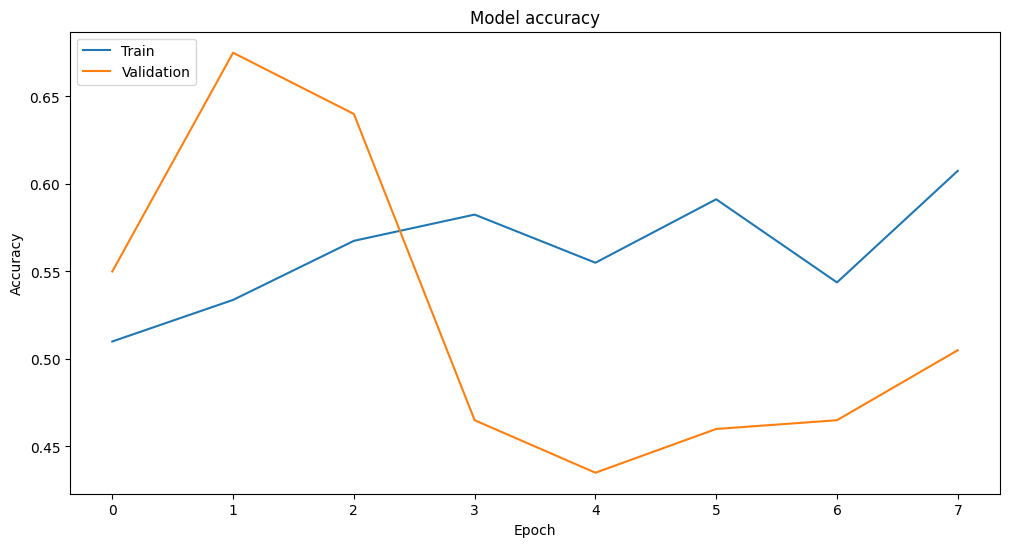

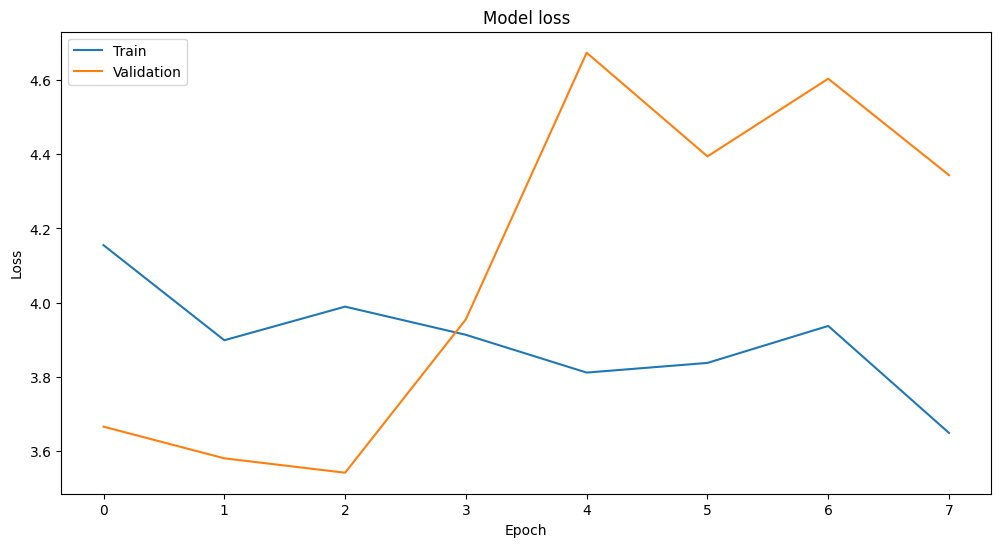

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(32, kernel_size=3, strides=2, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(256, 256, 3)),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.5),

        layers.Conv2D(64, kernel_size=3, strides=2, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.ZeroPadding2D(((0,1), (0,1))),
        layers.BatchNormalization(momentum=0.82),
        layers.LeakyReLU(alpha=0.25),
        layers.Dropout(0.5),

        layers.Conv2D(128, kernel_size=3, strides=2, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.BatchNormalization(momentum=0.82),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.5),

        layers.Conv2D(256, kernel_size=3, strides=1, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.BatchNormalization(momentum=0.8),
        layers.LeakyReLU(alpha=0.25),
        layers.Dropout(0.5),

        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])


augmented_train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y))

loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)


discriminator_model = build_discriminator()


discriminator_model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = discriminator_model.fit(
    augmented_train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stopping]
)


test_loss, test_accuracy = discriminator_model.evaluate(test_dataset)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
